# Introduction

This is a map-reduce version of expectation maximization algo for K means model.  There are two mrJob MR packages, mr_kMeansIterate and mr_kMeansInitialize.  The driver calls the mrJob packages and manages the iteration. 

#Data Generation

In [1]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

# Data Visualiazation

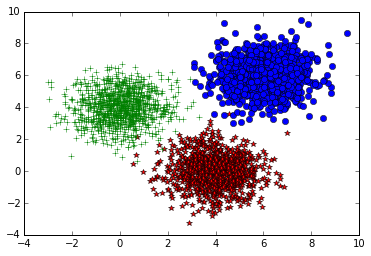

In [2]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

# Initialization

Here suppose we know there are 3 clusters, so we initialize three centroids

In [3]:
%%writefile mr_kMeansInitialize.py
from mrjob.job import MRJob


import random
import simplejson as json

class MRkMeansInit(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MRkMeansInit, self).__init__(*args, **kwargs)
        self.centroids = []                  #current centroid list
        self.numMappers = 1             #number of mappers
        self.count = 0
        
                                                 
    def configure_options(self):
        super(MRkMeansInit, self).configure_options()
        self.add_passthrough_option(
            '--k', dest='kMeans', type='int',
            help='k: number of means (cluster centroids)')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
        
    def mapper(self, key, xjIn):
        #something simple to grab random starting point
        #collect the first 2k
        if self.count <= 2*self.options.kMeans:
            self.count += 1
            yield (1,xjIn)        
        
    def reducer(self, key, xjIn):        
        #accumulate data points mapped to 0 from 1st mapper and pull out k of them as starting point
        cent = []
        for xj in xjIn:
            x = json.loads(xj)
            cent.append(x)
            yield 1, xj
        index = random.sample(range(len(cent)), self.options.kMeans)
        cent2 = []
        for i in index:
            cent2.append(cent[i])
               
        centOut = json.dumps(cent2)
        #put centroids onto file to load in at next instantiation of "self"
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(centOut)
        fileOut.close()

if __name__ == '__main__':
    MRkMeansInit.run()

Overwriting mr_kMeansInitialize.py


# Iteration

In [4]:
%%writefile mr_kMeansIterate.py
from mrjob.job import MRJob

from math import sqrt

from random import sample
import simplejson as json

def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

def plus(x,y):
    #"vector" sum of two lists
    length = len(x)
    sum = [0.0]*length
    for i in range(length):
        sum[i] = x[i] + y[i]
    return sum
        
def divide(x,alpha):
    length = len(x)
    div = [0.0]*length
    for i in range(length):
        div[i] = x[i]/alpha
    return div

class MRkMeansIter(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MRkMeansIter, self).__init__(*args, **kwargs)
        self.centroids = []                  #current centroid list
        self.new_centroid = []
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileIn = open(fullPath)
        centroidsJson = fileIn.read()
        fileIn.close()
        self.centroids = json.loads(centroidsJson)
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
        self.count2 = []                #contributors to new_centroid calc in each mapper
                                                 
    def configure_options(self):
        super(MRkMeansIter, self).configure_options()

        self.add_passthrough_option(
            '--k', dest='kMeans', default=2, type='int',
            help='k: number of means (cluster centroids)')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
        
    def mapper(self, key, val):
        #determine closest centroid for each val in input
        #map each val onto closest centroid 
        x = json.loads(val)
        
        if self.count == 0:
            #initialize this mapper's copy of self.new_centroid to zero
            #initialize this mapper's copy of self.count2 to all zeros
            self.count = 1
            self.new_centroid = []
            self.count2 = [0.0]*self.options.kMeans
            for i in range(self.options.kMeans):
                temp = [0.0]*len(x)
                self.new_centroid.append(temp)
                        
        
        dist1 = dist(x,self.centroids[0])
        index = 0
        for i in range(1,self.options.kMeans):
            dist2 = dist(x,self.centroids[i])
            if(dist2 < dist1):
                index = i
                dist1 = dist2
        self.count2[index] += 1
        temp = self.new_centroid[index]
        self.new_centroid[index] = plus(temp,x)
        if False: yield 1,2
        
    def mapper_final(self):
        out = [self.new_centroid,self.count2]
        jOut = json.dumps(out)
        yield 1,jOut
    
    
    def reducer(self, key, xs):
        #add up the centroid sums from all the mappers
        #add up the number of points in each centroid calc from each mapper
        counts = [0.0]*self.options.kMeans
        centroid_sum = []
        first = True
        #accumulate partial sums
        for val in xs:
            if first:
                temp = json.loads(val)
                cent = temp[0]
                cnt = temp[1]
                centroid_sum = cent
                counts = cnt
                first = False
            else:
                temp = json.loads(val)
                cent = temp[0]
                cnt = temp[1]
                for k in range(self.options.kMeans):
                    temp = centroid_sum[k]
                    centroid_sum[k] = plus(temp,cent[k])
                    counts[k] = counts[k] + cnt[k]
        #divide grand sum by number of points
        newCentroid = []
        for k in range(self.options.kMeans):
            newCentroid.append(divide(centroid_sum[k],counts[k]))
            
        #write new centroids to file
        centOut = json.dumps(newCentroid)
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(centOut)
        fileOut.close()
            

if __name__ == '__main__':
    MRkMeansIter.run()

Overwriting mr_kMeansIterate.py


# Driver

[[-0.5282603449126969, 4.829009589678984], [3.4409365422359786, -1.122508052281444], [4.826042170550334, 8.631644747742321]]
Iteration:0
[[-0.5282603449126969, 4.829009589678984], [3.4409365422359786, -1.122508052281444], [4.826042170550334, 8.631644747742321]]


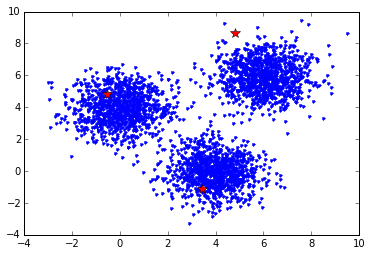

Iteration:1
[[0.022822445310167437, 4.018880415821798], [3.9395376887211575, 0.022518901439182722], [6.01796735535829, 5.981080431841846]]


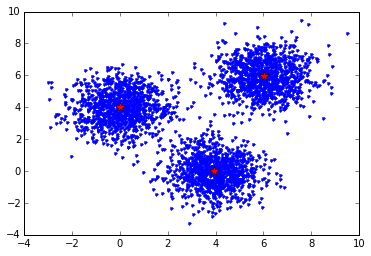

Iteration:2
[[0.019614322666332125, 4.013134589314149], [3.933758461134757, -0.004845065874678675], [6.012168164862961, 5.956582696053107]]


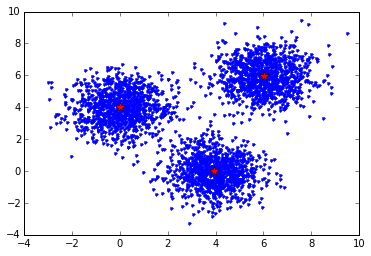

Iteration3
[[0.019614322666332125, 4.013134589314149], [3.933758461134757, -0.004845065874678675], [6.012168164862961, 5.956582696053107]]


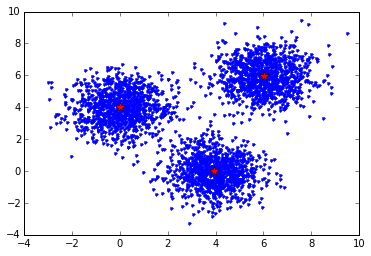

In [6]:
from mr_kMeansInitialize import MRkMeansInit
from mr_kMeansIterate import MRkMeansIter
import simplejson as json
from math import sqrt

def plot_iteration(centroids):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(centroids[0][0], centroids[0][1],'*',markersize =10,color = 'red')
    pylab.plot(centroids[1][0], centroids[1][1],'*',markersize =10,color = 'red')
    pylab.plot(centroids[2][0], centroids[2][1],'*',markersize =10,color = 'red')
    pylab.show()

def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

#first run the initializer to get starting centroids
filePath = 'data.txt'    
kMeansStr = '3'
mrJob = MRkMeansInit([filePath] + ["--k" , kMeansStr])
#mrJob = MRkMeansInit(args=[filePath])
with mrJob.make_runner() as runner:
    runner.run()
    
fileIn = open("intermediateResults.txt")
centroidsJson = fileIn.read()
fileIn.close()
    
delta = 10
iter_num = 0
#Begin iteration on change in centroids
while delta > 0.01:
    print "Iteration:"+str(iter_num)
    iter_num = iter_num + 1
    #parse old centroid values
    oldCentroids = json.loads(centroidsJson)
    #run one iteration
    mrJob2 = MRkMeansIter(args=[filePath] + ["--k" , kMeansStr])
    with mrJob2.make_runner() as runner:
        runner.run()

    #compare new centroids to old ones
    fileIn = open("intermediateResults.txt")
    centroidsJson = fileIn.read()
    fileIn.close()
    newCentroids = json.loads(centroidsJson)

    kMeans = len(newCentroids)

    delta = 0.0
    for i in range(kMeans):
        delta += dist(newCentroids[i],oldCentroids[i])
    print oldCentroids
    plot_iteration(oldCentroids)
print "Iteration" + str(iter_num)
print newCentroids
plot_iteration(newCentroids)